<a href="https://colab.research.google.com/github/yash-garg274/Medical-Image-Segmentaion/blob/main/R2U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pickle
from importlib import reload
import sys
sys.path.append('files')

import tensorflow as tf
import numpy as np
import accuracy
import r2u_model
import rbv_model 

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [ ]:
!unzip rbv.zip

Streaming output truncated to the last 5000 lines.
  inflating: rbv/patches/patch_img/img_004189.jpg  
  inflating: rbv/patches/patch_img/img_004484.jpg  
  inflating: rbv/patches/patch_img/img_010344.jpg  
  inflating: rbv/patches/patch_img/img_006310.jpg  
  inflating: rbv/patches/patch_img/img_008654.jpg  
  inflating: rbv/patches/patch_img/img_004071.jpg  
  inflating: rbv/patches/patch_img/img_010615.jpg  
  inflating: rbv/patches/patch_img/img_004555.jpg  
  inflating: rbv/patches/patch_img/img_009635.jpg  
  inflating: rbv/patches/patch_img/img_002780.jpg  
  inflating: rbv/patches/patch_img/img_007441.jpg  
  inflating: rbv/patches/patch_img/img_002689.jpg  
  inflating: rbv/patches/patch_img/img_011333.jpg  
  inflating: rbv/patches/patch_img/img_006085.jpg  
  inflating: rbv/patches/patch_img/img_010844.jpg  
  inflating: rbv/patches/patch_img/img_006102.jpg  
  inflating: rbv/patches/patch_img/img_008684.jpg  
  inflating: rbv/patches/patch_img/img_002765.jpg  
  inflating: 

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
wt = tf.constant([0.2,0.7], dtype = tf.dtypes.float32)
norm = ''
def weighted_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.dtypes.int32)
    weights = tf.gather(wt, y_true)
    if norm == 'sig':
        err = tf.nn.sparse_softmax_cross_entropy_with_logits(y_true, y_pred)
    elif norm == 'softmax':
        err = tf.nn.sparse_sigmoid_cross_entropy_with_logits(y_true, y_pred)
    else:
        err = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    err = err*weights
    return err


In [ ]:
inputs = tf.zeros((1,128,128,3))
model1 = r2u_model.R2UNET(ch_init = 16, sig = True)
out = model1(inputs, False)

####tf exclusive
train_gen, val_gen = rbv_model.tf_dataset('rbv/patches/patch_img', 'rbv/patches/patch_gt', batch_trn = 30, batch_val=20, cache = 'cache0', img_wise_norm = True)


model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),          
              loss= weighted_error,
              metrics=['accuracy', accuracy.F1, accuracy.SE, accuracy.SP, accuracy.JS, accuracy.DC])

In [ ]:
history1 = model1.fit(train_gen, steps_per_epoch = 100, epochs = 40, validation_data = val_gen, validation_steps = 10)
model1.save('model/save_model')

Epoch 1/40
100/100 [==============================] - 54s 543ms/step - loss: 0.0563 - accuracy: 0.8479 - F1: 0.4498 - SE: 0.4343 - SP: 0.9696 - JS: 0.3616 - DC: 0.4501 - val_loss: 0.0852 - val_accuracy: 0.8107 - val_F1: 0.3918 - val_SE: 0.4034 - val_SP: 0.9313 - val_JS: 0.2895 - val_DC: 0.3921
Epoch 2/40
100/100 [==============================] - 54s 543ms/step - loss: 0.0521 - accuracy: 0.8535 - F1: 0.4627 - SE: 0.4492 - SP: 0.9718 - JS: 0.3761 - DC: 0.4630 - val_loss: 0.0942 - val_accuracy: 0.8132 - val_F1: 0.3929 - val_SE: 0.3913 - val_SP: 0.9365 - val_JS: 0.2900 - val_DC: 0.3931
Epoch 3/40
100/100 [==============================] - 54s 543ms/step - loss: 0.0500 - accuracy: 0.8535 - F1: 0.4657 - SE: 0.4511 - SP: 0.9732 - JS: 0.3798 - DC: 0.4660 - val_loss: 0.0915 - val_accuracy: 0.8042 - val_F1: 0.4069 - val_SE: 0.4233 - val_SP: 0.9208 - val_JS: 0.2968 - val_DC: 0.4071
Epoch 4/40
100/100 [==============================] - 54s 543ms/step - loss: 0.0476 - accuracy: 0.8544 - F1: 0.4766

INFO:tensorflow:Assets written to: model/save_model/assets


INFO:tensorflow:Assets written to: model/save_model/assets


In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, -1)
    # pred_mask = pred_mask[..., tf.newaxis]
    # print(pred_mask.shape)
    return pred_mask

In [ ]:
val_it = iter(val_gen)

In [ ]:
k = next(val_it)

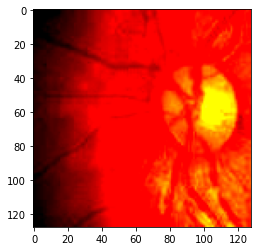

In [ ]:
plt.imshow(k[0][0])

In [ ]:
out = model1.predict(k[0])

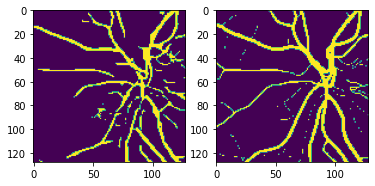

In [ ]:
plt.subplot(84)
plt.imshow(create_mask(out[0]))
plt.subplot(73)
plt.imshow(k[1][0])

In [ ]:
from PIL import Image
test_img = []
gt_img = []
test_mask = []
test_files = [os.path.abspath(os.path.join('rbv/test', i)) for i in os.listdir('rbv/test')]
for i in test_files:
    test = np.asarray(Image.open(i), dtype = "float32") / 255.
    patches = tf.image.extract_patches(test[tf.newaxis, ...], [1,128,128,1], strides = [1,128,128,1], rates = [1,1,1,1], padding = 'VALID')
    inputs = tf.map_fn(tf.image.per_image_standardization, tf.reshape(patches, (4, 128, 128, 3)))
    outputs = create_mask(model1.predict(inputs))
    mask = tf.concat([ tf.concat([outputs[0], outputs[1]], axis = 1) , tf.concat([outputs[2], outputs[3]], axis = 1)], axis = 0 )
    test_img.append(test)
    test_mask.append(mask)

In [ ]:
from PIL import Image
test_path = 'rbv/img256' 
mask_path = 'rbv/gt256/'
test_img = []
test_gt = []
test_mask = []
test_files = sorted([os.path.abspath(os.path.join(test_path, i)) for i in os.listdir(test_path)])
mask_files = sorted([os.path.abspath(os.path.join(mask_path, i)) for i in os.listdir(mask_path)])
for i in range(len(test_files)):
    test = np.asarray(Image.open(test_files[i]), dtype = "float32") / 255.
    patches = tf.image.extract_patches(test[tf.newaxis, ...], [1,128,128,1], strides = [1,128,128,1], rates = [1,1,1,1], padding = 'VALID')
    inputs = tf.map_fn(tf.image.per_image_standardization, tf.reshape(patches, (4, 128, 128, 3)))
    outputs = create_mask(model1.predict(inputs))
    mask = tf.concat([ tf.concat([outputs[0], outputs[1]], axis = 1) , tf.concat([outputs[2], outputs[3]], axis = 1)], axis = 0 )
    test_img.append(test)
    test_mask.append(mask)
    gt = np.asarray(Image.open(mask_files[i]), dtype = "float32") / 255.
    test_gt.append(gt)
print(len(test_files))

68


In [ ]:
i = 0
!mkdir rbv_test_res
%cd rbv_test_res
!mkdir rbv_val
%cd rbv_val

for i in range(len(test_img)):
    tf.keras.preprocessing.image.array_to_img(test_img[i]).save('img%d.jpg'%i)
    tf.keras.preprocessing.image.array_to_img(test_mask[i][..., tf.newaxis]).save('mask%d.jpg'%i)
    tf.keras.preprocessing.image.array_to_img(test_gt[i][..., tf.newaxis]).save('gt%d.jpg'%i)
    # plt.subplot(121)
    # plt.imshow(test_img[i])
    # plt.subplot(122)
    # plt.imshow(test_mask[i], cmap = 'gray')
# test_ma
%cd /content/

mkdir: cannot create directory ‘rbv_test_res’: File exists
/content/rbv_test_res
/content/rbv_test_res/rbv_val
/content


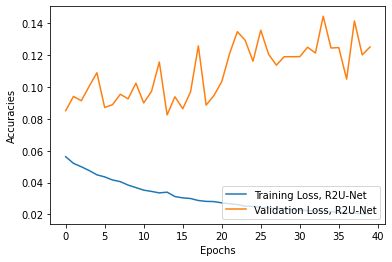

In [ ]:
# unet_acc = history1.history['acc']
# unet_val_acc = history1.history['val_acc']
r2unet_acc = history1.history['loss']
r2unet_val_acc = history1.history['val_loss']
%mkdir data/rbv_graph
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
# plt.ylim([0.7,1])
# plt.plot(unet_acc, label='Training Accuracy, U-Net' )
# plt.plot(unet_val_acc, label='Validation Accuracy, U-Net')
plt.plot(r2unet_acc, label='Training Loss, R2U-Net' )
plt.plot(r2unet_val_acc, label='Validation Loss, R2U-Net')
plt.legend(loc='lower right')
# plt.show()
plt.savefig('data/rbv_graph/graph_loss.png')

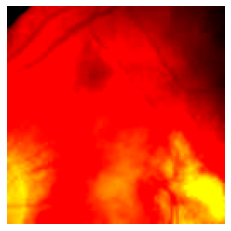

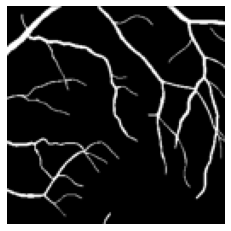

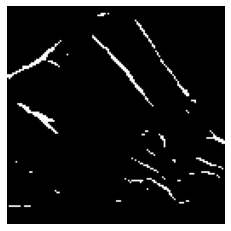

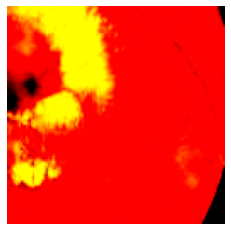

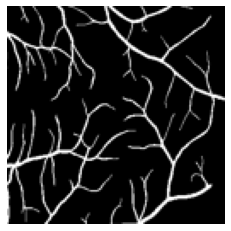

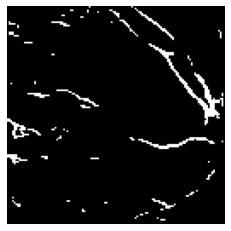

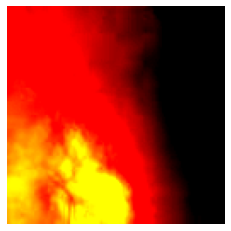

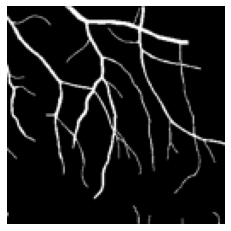

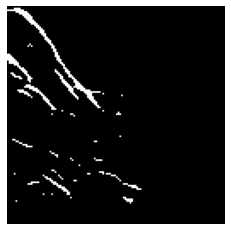

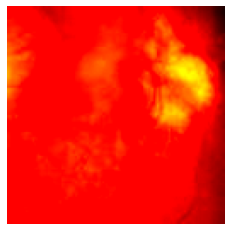

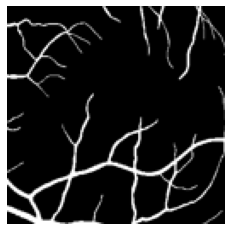

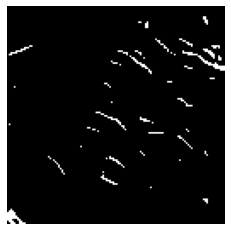

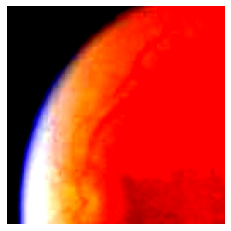

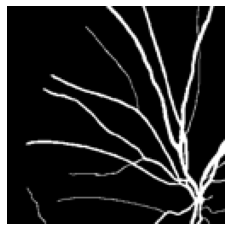

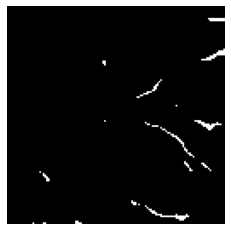

In [ ]:
train_it = iter(train_gen) 
k = next(train_it)
out1 = model1.predict(k[0])

def create_mask(pred_mask):
    pred_mask = tf.cast(tf.argmax(pred_mask, -1), tf.dtypes.float32)
    return pred_mask

for i in range(5):
    plt.figure()
    plt.imshow(k[0][i])
    plt.axis('off')
    plt.savefig(f'data/rbv_graph/orig_{i}.png')
    plt.figure()
    plt.imshow(k[1][i], cmap = 'gray')
    plt.axis('off')
    plt.savefig(f'data/rbv_graph/ground_{i}.png')
    plt.figure()
    ok1 = create_mask(out1[i])
    plt.imshow(ok1, cmap = 'gray')
    plt.axis('off')
    plt.savefig(f'data/rbv_graph/unet{i}.png')

In [ ]:
res = {}
for i in history1.history.keys():
    res[i] = max(history1.history[i])

In [ ]:
res

{'DC': 0.6255459189414978,
 'F1': 0.6253707408905029,
 'JS': 0.519991397857666,
 'SE': 0.5828315615653992,
 'SP': 0.9833002686500549,
 'accuracy': 0.8769397735595703,
 'loss': 0.05630551278591156,
 'val_DC': 0.44316959381103516,
 'val_F1': 0.4429222047328949,
 'val_JS': 0.34360256791114807,
 'val_SE': 0.42334142327308655,
 'val_SP': 0.9887916445732117,
 'val_accuracy': 0.8464413285255432,
 'val_loss': 0.14455841481685638}